# Testing separation method vs. one-hot encoding on the Abalone data set

In [1]:
# formatting
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important, }</style>")
%matplotlib inline

In [2]:
# formatting
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important, }</style>")
%matplotlib inline

# packages
from importlib import reload
import numpy as np
from matplotlib import pyplot as plt
from adhocMLP import NN
from adhocMLP import functions

## A test: learn x^2+y^2

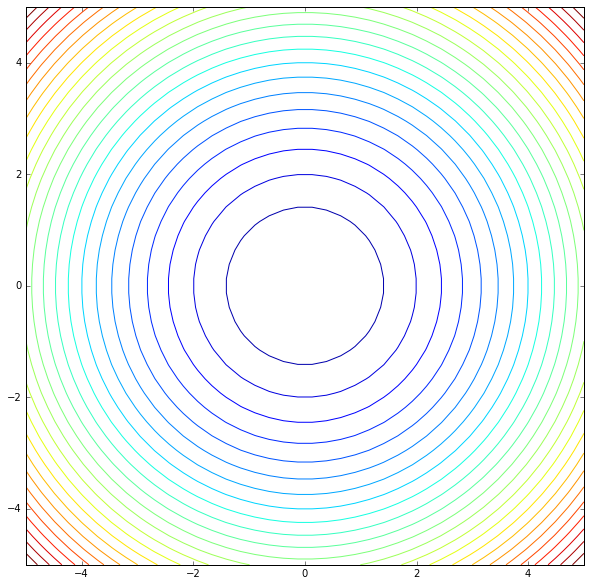

In [3]:
# 40 by 40 grid- 1600 points
x = np.linspace(-5,5,40)
y = x
xx,yy = np.meshgrid(x,y)
X = np.c_[xx.ravel(),yy.ravel()]
y = np.apply_along_axis(lambda row: np.sum(np.square(row)), 1, X)

level_lines = np.arange(0,50,2)
# Generate a dataset and plot it
plt.rcParams['figure.figsize'] = 10,10
plt.contour(xx,yy,y.reshape(xx.shape), level_lines)
#plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [27]:
# Let's try to learn it
# initialize a network:
network = NN.CategoricalNN(h_layer_sizes=[6,3,2],activation=functions.tanh,
                      output_activation=functions.identity,loss=functions.squared_loss,bias=True)
# train it
network.train(X,y,learning_rate=0.005,epochs=30000,report_interval=2000,batch_size=300,stochastic=True,momentum=1.0,reg_lambda=0.1, init_weight_sd=2.0)

squared_loss loss (Training) after training epoch 2000: 2.2463195874028083.
*** New minimum training loss: 2.2463195874028083
squared_loss loss (Training) after training epoch 4000: 0.4094649824068901.
*** New minimum training loss: 0.4094649824068901
squared_loss loss (Training) after training epoch 6000: 0.3646844857432312.
*** New minimum training loss: 0.3646844857432312
squared_loss loss (Training) after training epoch 8000: 0.6465364835085949.
squared_loss loss (Training) after training epoch 10000: 0.3351954319711885.
*** New minimum training loss: 0.3351954319711885
squared_loss loss (Training) after training epoch 12000: 0.18382224643605052.
*** New minimum training loss: 0.18382224643605052
squared_loss loss (Training) after training epoch 14000: 0.21906731112557865.
squared_loss loss (Training) after training epoch 16000: 0.15810246485701285.
*** New minimum training loss: 0.15810246485701285
squared_loss loss (Training) after training epoch 18000: 0.24820846963031248.
squar

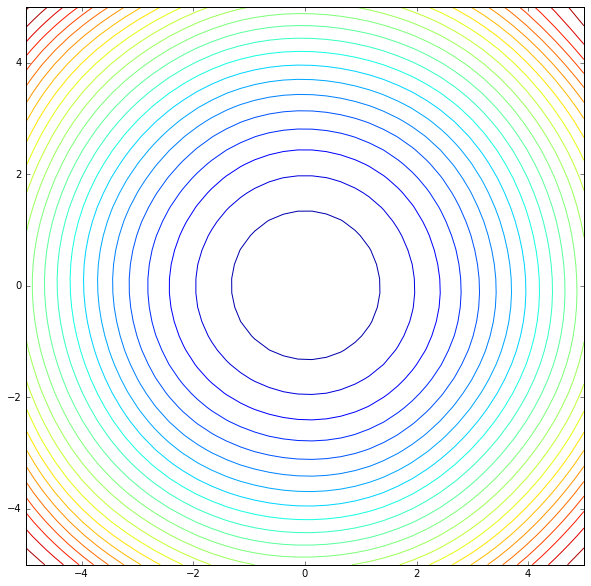

In [28]:
# looks good! Let's plot the results
plt.rcParams['figure.figsize'] = 10,10
y_pred = network.predict(X)
plt.contour(xx,yy,y_pred.reshape(xx.shape),level_lines)

In [36]:
# Not too shabby!  squared loss ~0.044 on a function with a range from 0 to 50.  That translates to an MSE of ~0.297
# Now, let's try it on the Abalone dataset

### first, read in the data

In [3]:
import pandas as pd
abalone = pd.read_csv('abalone.data',header=None)
abalone.columns = ["Sex", "Length", "Diameter", "Height", "Whole", "Shucked", "Viscera", "Shell", "Rings"]
abalone.head(5)

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# First off, we'll try the worst method: encode sex as numeric with a label encoder
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
label_enc.fit(abalone.Sex)

abalone.Sex = label_enc.transform(abalone.Sex)
abalone.head(5)

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
# Looks good. Now let's split into training and testing data
from sklearn.cross_validation import train_test_split
X = abalone.iloc[:,0:7].values
y = abalone.iloc[:,8].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)

## Trial 1: label encoding: pass X and y as-is with the Sex column encoded as 0-1-2

In [17]:
# Our neural network class will report test error as it trains if we supply test data.
# let's do that and see how the test error performs.
# We'll first go for 3 hidden nodes since this is what Brouwer does.
# Other choices:
#    - tanh activation
#    - squared loss
#    - bias terms
network1 = NN.CategoricalNN(h_layer_sizes=[4,4,4],activation=functions.tanh,
                             loss=functions.squared_loss,bias=True)

In [18]:
# Train it. The learning rate is normalized to the training size, so we don't have to worry about adjusting it.
network1.train(X,y,0.05,10000,X_test=X_test,y_test=y_test,report_interval = 5000,init_weight_sd=0.02,stochastic=True,
              batch_size=50,reg_lambda = 1)

squared_loss loss (Training) after training epoch 5000: 2.08102298519306.
*** New minimum test loss: 2.08102298519306
squared_loss loss (Training) after training epoch 10000: 2.064328057297207.
*** New minimum test loss: 2.064328057297207


In [12]:
# Test error is consistently declining over the whole range of epochs, but considerably less so toward the end.
# Minimum test error: ~1.938

## Trial 2: one-hot encoding: Add 3 new binary features according to the values of the Sex column

In [13]:
# same choices as before, but with a different encoding method.  The NN class handles all the encoding on the back end.
network2 = NN.CategoricalNN(h_layer_sizes=3,activation=functions.tanh,
                             loss=functions.squared_loss,bias=True)

In [14]:
network2.train(X,y,0.03,10000,X_test=X_test,y_test=y_test,report_interval = 1000,
               categorical_method='one-hot',categorical_indices=[0])

squared_loss loss (Training) after training epoch 1000: 2.077341924696694.
*** New minimum test loss: 2.077341924696694
squared_loss loss (Training) after training epoch 2000: 2.0344316921123076.
*** New minimum test loss: 2.0344316921123076
squared_loss loss (Training) after training epoch 3000: 2.0126281127736596.
*** New minimum test loss: 2.0126281127736596
squared_loss loss (Training) after training epoch 4000: 2.001741137261874.
*** New minimum test loss: 2.001741137261874
squared_loss loss (Training) after training epoch 5000: 1.9958734406015641.
*** New minimum test loss: 1.9958734406015641
squared_loss loss (Training) after training epoch 6000: 1.9913896978592192.
*** New minimum test loss: 1.9913896978592192
squared_loss loss (Training) after training epoch 7000: 1.986023293337626.
*** New minimum test loss: 1.986023293337626
squared_loss loss (Training) after training epoch 8000: 1.978194861025144.
*** New minimum test loss: 1.978194861025144
squared_loss loss (Training) aft

In [15]:
# pretty similar to the naive method; 
# Minimum test error: ~1.951

In [16]:
# Here's proof of the encoding method:
print(network2.encode(X[0:5,:]))
print(network2.categorical_method)
print(network2.quant_indices)
print(network2.input_layer_size)

[[-0.57448935 -0.43209706 -1.06429672 -0.64182139 -0.60761262 -0.72612464
   0.          0.          1.        ]
 [-1.44881239 -1.43975662 -1.18383657 -1.23012983 -1.17076967 -1.20507696
   0.          0.          1.        ]
 [ 0.0500271   0.1221157  -0.10797794 -0.30943221 -0.46344441 -0.35664713
   1.          0.          0.        ]
 [-0.69939264 -0.43209706 -0.34705763 -0.63774299 -0.64815993 -0.60752692
   0.          0.          1.        ]
 [-1.61535011 -1.54052258 -1.42291627 -1.27193338 -1.21582223 -1.28718308
   0.          1.          0.        ]]
one-hot
[1, 2, 3, 4, 5, 6]
9


In [17]:
# Just for a sanity check, let's look at the layer sizes:
print([w.shape for w in network1.weights])
print([b.shape for b in network1.biases])
print([w.shape for w in network2.weights])
print([b.shape for b in network2.biases])
# 9 inputs for the one-hot encoded version: take off the sex column and add 3 more, one for each value

[(7, 10), (10, 10), (10, 1)]
[(1, 10), (1, 10), (1, 1)]
[(9, 10), (10, 10), (10, 1)]
[(1, 10), (1, 10), (1, 1)]


## Trial 3: separation encoding- repeated output layer, one for each categorical input combination.  Delta on the output layer is masked with a 0-1 matrix encoding the categorical input values.  Method described in:
#### Brouwer, Roelof K. "A feed-forward network for input that is both categorical and quantitative." Neural Networks 15.7 (2002): 881-890.

In [22]:
# same choices as before, but with a different encoding method.  The NN class handles all the encoding on the back end.
network3 = NN.CategoricalNN(h_layer_sizes=[10,10],activation=functions.logistic,
                             loss=functions.squared_loss,bias=True)

In [23]:
# Let's train it.  Specify 'separation' for the categorical_method
network3.train(X,y,0.03,10000,X_test=X_test,y_test=y_test,report_interval = 1000,
               categorical_method='separation',categorical_indices=[0])

squared_loss loss (Training) after training epoch 1000: 2.894842353003666.
*** New minimum test loss: 2.894842353003666
squared_loss loss (Training) after training epoch 2000: 2.40063478985937.
*** New minimum test loss: 2.40063478985937
squared_loss loss (Training) after training epoch 3000: 2.2312190618673093.
*** New minimum test loss: 2.2312190618673093
squared_loss loss (Training) after training epoch 4000: 2.147387211361959.
*** New minimum test loss: 2.147387211361959
squared_loss loss (Training) after training epoch 5000: 2.1147328042964797.
*** New minimum test loss: 2.1147328042964797
squared_loss loss (Training) after training epoch 6000: 2.1031320824602626.
*** New minimum test loss: 2.1031320824602626
squared_loss loss (Training) after training epoch 7000: 2.0976341940976724.
*** New minimum test loss: 2.0976341940976724
squared_loss loss (Training) after training epoch 8000: 2.0939292964036413.
*** New minimum test loss: 2.0939292964036413
squared_loss loss (Training) aft

In [20]:
# here's what the mask on the output layer looks like
network3.mask(X_test)[0:10,]

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [21]:
# Let's take a look at the output layer sizes just to be sure:
print([w.shape for w in network3.weights])
print([b.shape for b in network3.biases])
# Notice the weight matrix feeding into the output layer is 10*3, one column for each categorical value.

[(6, 10), (10, 10), (10, 3)]
[(1, 10), (1, 10), (1, 3)]
